Fetching AAPL data for the last 1y...


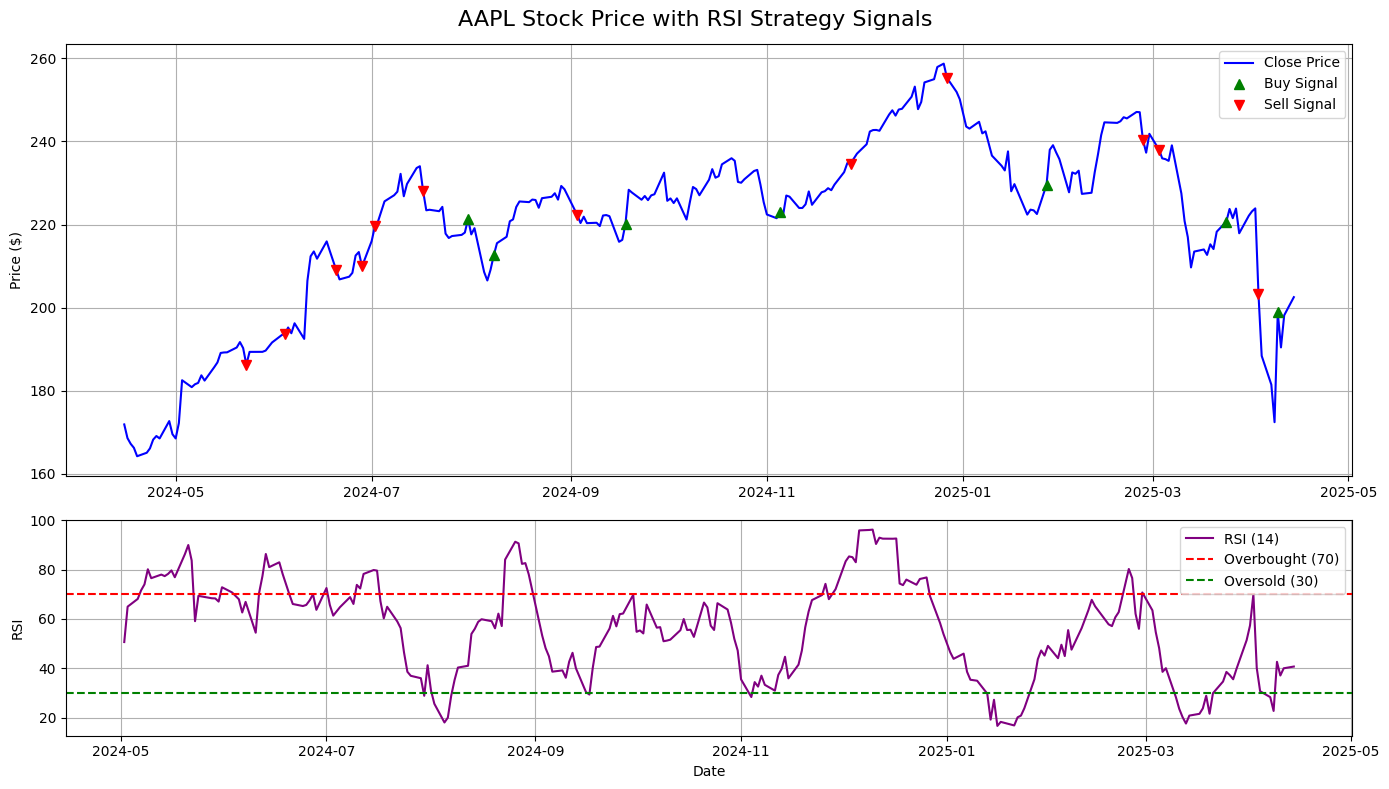

Win rate: 55.56% (10 wins out of 18 trades)


In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def fetch_stock_data(ticker, period= '1y'):
    """Fetches historical stock data for a given ticker from Yahoo Finance.

    Args:
        ticker (str): Stock symbol to fetch data for (e.g., 'AAPL')
        period (str, optional): Time period to fetch data for. Defaults to '1y'.
            Valid periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max

    Returns:
        pandas.DataFrame: DataFrame containing historical stock data (Open, High, Low, Close, etc.)
        None: If data fetch fails or returns empty

    Raises:
        ValueError: If the returned data is empty
    """
    try:
        print(f"Fetching {ticker} data for the last {period}...")
        stock = yf.Ticker(ticker)
        data = stock.history(period= period)

        if data.empty:
            raise ValueError("No data returned from Yahoo Finance")
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

def calculate_rsi(data, window= 14):
    """Calculates the Relative Strength Index (RSI) for given stock data.

    Args:
        data (pandas.DataFrame): DataFrame containing stock data with 'Close' prices
        window (int, optional): Lookback window for RSI calculation. Defaults to 14.

    Returns:
        pandas.Series: Series containing RSI values
        None: If calculation fails

    Raises:
        ValueError: If input data doesn't contain 'Close' column
    """
    try:
        if 'Close' not in data.columns:
            raise ValueError("Data must contain 'Close' column")

        delta = data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window= window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window= window).mean()

        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    except Exception as e:
        print(f"Error calculating RSI: {str(e)}")
        return None

def generate_signals(data, rsi):
    """Generates buy/sell signals based on reverse RSI trigger logic.

    Sell after RSI exceeds 70 and comes back down to 70.
    Buy after RSI drops below 30 and comes back up to 30.
    """
    try:
        signals = pd.DataFrame(index=data.index)
        signals['Price'] = data['Close']
        signals['RSI'] = rsi
        signals['Signal'] = 0

        wait_for_sell_trigger = False
        wait_for_buy_trigger = False

        for i in range(1, len(rsi)):
            current_rsi = rsi.iloc[i]

            # Step 1: Wait for RSI to go above 70
            if current_rsi > 70:
                wait_for_sell_trigger = True

            # Step 2: RSI drops back to 70 → trigger SELL
            elif current_rsi <= 70 and wait_for_sell_trigger:
                signals.iloc[i, signals.columns.get_loc('Signal')] = -1  # Sell
                wait_for_sell_trigger = False

            # Step 1: Wait for RSI to go below 30
            if current_rsi < 30:
                wait_for_buy_trigger = True

            # Step 2: RSI comes back up to 30 → trigger BUY
            elif current_rsi >= 30 and wait_for_buy_trigger:
                signals.iloc[i, signals.columns.get_loc('Signal')] = 1  # Buy
                wait_for_buy_trigger = False

        return signals
    except Exception as e:
        print(f"Error generating signals: {str(e)}")
        return None

def plot_price_rsi_signals(data, rsi, signals, ticker):
    """Plots stock price, RSI, and trading signals in a 2-panel visualization.

    Args:
        data (pandas.DataFrame): DataFrame containing stock data
        rsi (pandas.Series): Series containing RSI values
        signals (pandas.DataFrame): DataFrame containing trading signals
        ticker (str): Stock symbol for plot title

    Returns:
        None: Displays matplotlib plot

    Note:
        Upper panel shows price with buy/sell signals
        Lower panel shows RSI with overbought/oversold levels
    """
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
                                     gridspec_kw={'height_ratios': [2, 1]})
        fig.suptitle(f'{ticker} Stock Price with RSI Strategy Signals', fontsize=16)

        # Price chart
        ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
        ax1.set_ylabel('Price ($)')
        ax1.grid(True)

        # Plot Buy signals
        buy_signals = signals[signals['Signal'] == 1]
        ax1.plot(buy_signals.index, buy_signals['Price'], '^',
                color='green', label='Buy Signal', markersize=7)

        # Plot Sell signals
        sell_signals = signals[signals['Signal'] == -1]
        ax1.plot(sell_signals.index, sell_signals['Price'], 'v',
                color='red', label='Sell Signal', markersize=7)
        ax1.legend()

        # RSI chart
        ax2.plot(rsi.index, rsi, label='RSI (14)', color='purple')
        ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
        ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
        ax2.set_ylabel('RSI')
        ax2.set_xlabel('Date')
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting signals: {str(e)}")

def calculate_win_rate(signals):
    """Calculates the win rate of the trading strategy.

    Args:
        signals (pandas.DataFrame): DataFrame containing trading signals

    Returns:
        None: Prints win rate statistics

    Note:
        A trade is considered successful if:
            - After a Buy signal, price increases
            - After a Sell signal, price decreases
        Win rate is calculated as (successful trades / total trades) * 100
    """
    try:
        trades = signals[signals['Signal'] != 0].copy()
        if len(trades) < 2:
            print("Not enough trades to calculate win rate.")
            return

        wins = 0
        total = 0

        for i in range(len(trades) - 1):
            entry = trades.iloc[i]
            exit = trades.iloc[i + 1]

            if entry['Signal'] == 1:  # Buy
                if exit['Price'] > entry['Price']:
                    wins += 1
            elif entry['Signal'] == -1:  # Sell
                if exit['Price'] < entry['Price']:
                    wins += 1
            total += 1

        win_rate = (wins / total) * 100 if total > 0 else 0
        print(f"\033[1mWin rate: {win_rate:.2f}% ({wins} wins out of {total} trades)\033[0m")
    except Exception as e:
        print(f"Error calculating win rate: {str(e)}")

def main():
    ticker = 'AAPL'
    rsi_window = 14
    time_period = '1y'

    stock_data = fetch_stock_data(ticker, time_period)

    if stock_data is not None:
        rsi = calculate_rsi(stock_data, rsi_window)

        if rsi is not None:
            signals = generate_signals(stock_data, rsi)

            if signals is not None:
                plot_price_rsi_signals(stock_data, rsi, signals, ticker)
                calculate_win_rate(signals)
            else:
                print("Failed to generate signals.")
        else:
            print("Failed to calculate RSI.")
    else:
        print("Failed to fetch stock data.")

if __name__ == "__main__":
    main()